# Understanding Autoencoders

**Introduction**

What is an autoencoder?
*   A special type of unsupervised (no labels needed) feedforward neural network
*   Captures the key aspects of the input data to provide a compressed version

Autoencoders are composed of two connected feedforward neural networks.


*   The **encoder** compresses the input data to remove noise and generates a latent space, where items that are similar to one another are close to each other.
*   The **decoder** uses the compressed data representation to reconstruct the original input data. This reconstruction can then be compared to the original input using a loss function.

**Types of Autoencoders**

There are many types of autoencoders that have been developed for a variety of applications.

*   Undercomplete Autoencoder
*   Sparse Autoencoder
*   Contractive Autoencoder
*   Denoising Autoencoder
*   Convolutional Autoencoder
*   Variational Autoencoder

![alttext](denoising_models/autoencoder.png)


# Denoising Autoencoders

In this notebook, we'll focus on denoising autoencoders. When the size of the latent space is equal to or greater than the size of the input, an autoencoder might learn the identity function during training. When this happens, the output will equal the input, meaning the autoencoder is not contributing anything.

**Simplified Theory**

Denoising autoencoders address this problem by intentionally corrupting the data. When calculating the loss function, we compare the output with the original input (not the corrupted input), eliminating the risk that the model learns the identity function. As a result, we train a model that takes in corrupted data and attempts to reconstruct uncorrupted data.

![alttext](denoising_models/denoise.png)

**Hands-On Example**

Let's start by building a denoising autoencoder.

We start with an input layer that takes in batches of images with size 28 pixels by 28 pixels. The input layer is then followed by a series of Convolutional and Max Pool layers that compress the images and extract features. Together, these initial layers will be our encoder.

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # Layer 1: Convolutional + Max Pooling
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Output: (16, 28, 28)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (16, 14, 14)
            # Layer 2: Convolutional + Max Pooling
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 14, 14)
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (32, 7, 7)
            # Layer 3: Convolutional + Max Pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (64, 7, 7)
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 3, 3)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.encoder(x)
        return x

    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
          if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Next we'll build the decoder. The architecture of the decoder is basically a reverse of the encoder, allowing us to obtain an image that matches the original dimensions.

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            # Layer 1: Transposed Convolution
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),  # Output: (32, 7, 7)
            nn.ReLU(True),
            # Layer 2: Transposed Convolution
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Output: (16, 14, 14)
            nn.ReLU(True),
            # Layer 3: Transposed Convolution
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid(),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.decoder(x)
        return x

    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.ConvTranspose2d):
          nn.init.xavier_normal_(m.weight)
          if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Let's piece together our encoder and decoder to define our denoising autoencoder.

In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Next, we'll need to prepare some training data. Let's intentionally corrupt some image data from the MNIST dataset to give us input data for our denoising autoencoder. We'll start by defining a function that adds noise to an image.

In [7]:
# Adding Guassian Noise to an image
def gaussian_noise(image):
    c, h, w = image.size()  # Assuming image is (channels, height, width) and grayscale
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    gaussian = torch.normal(mean, sigma, size=(h, w))
    noisy = image + gaussian
    return torch.clamp(noisy, min=0, max=1)

Let's use our noise function to corrupt the MNIST dataset. We should also make sure to remember what the uncorrupted images looked like so we can use them in our training later.

In [21]:
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torch import tensor
import numpy as np

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# corrupted MNIST images for training
mnist_corrupt_train = [(gaussian_noise(image), image) for image, _ in train_dataset]

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# corrupted MNIST images for testing
mnist_corrupt_test = [(gaussian_noise(image), image) for image, _ in test_dataset]

Let's plot some of the images in our training set to see what we're working with.

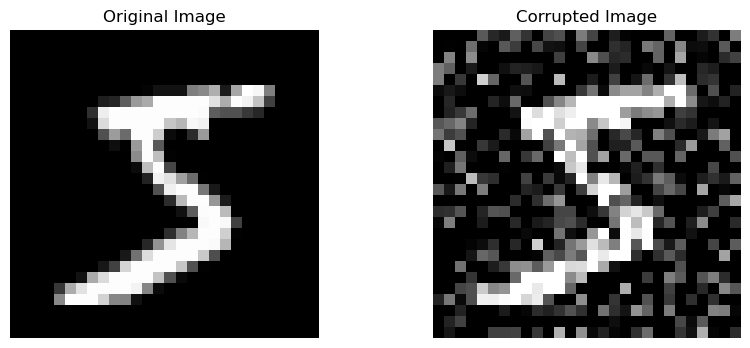

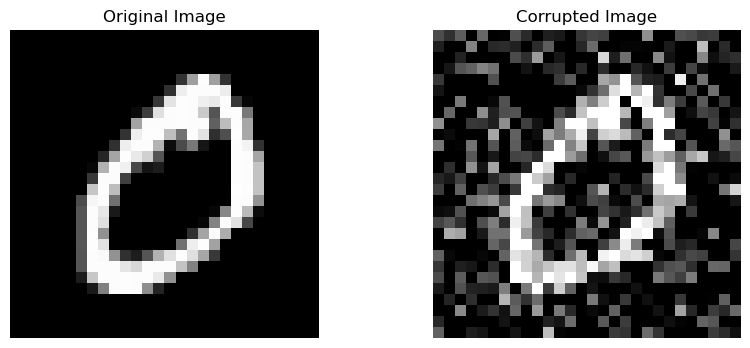

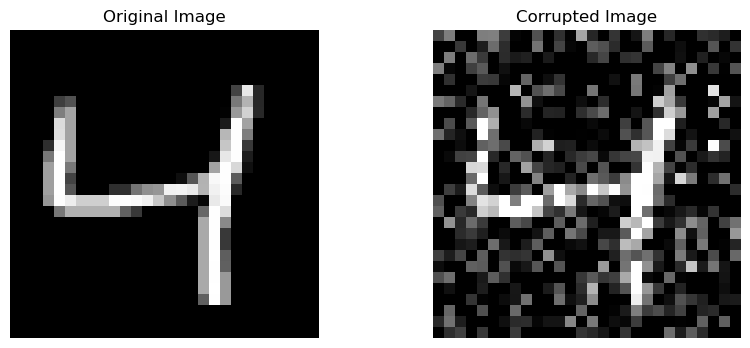

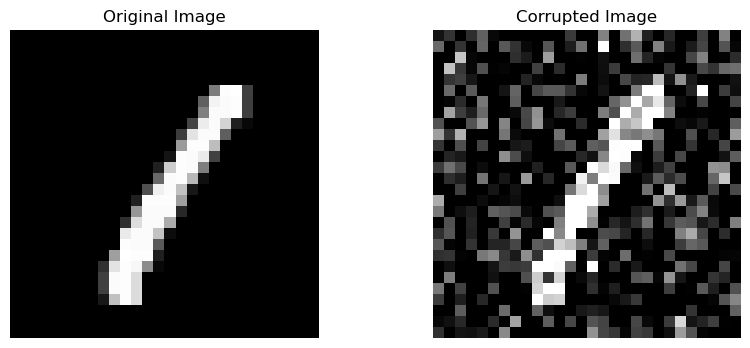

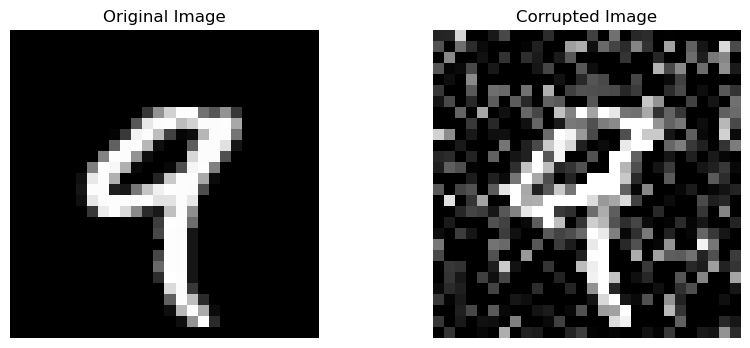

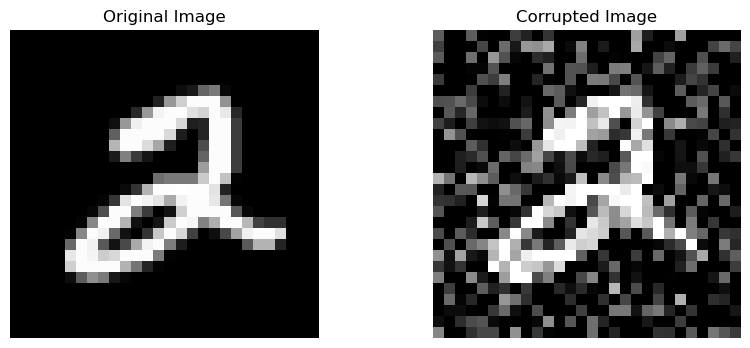

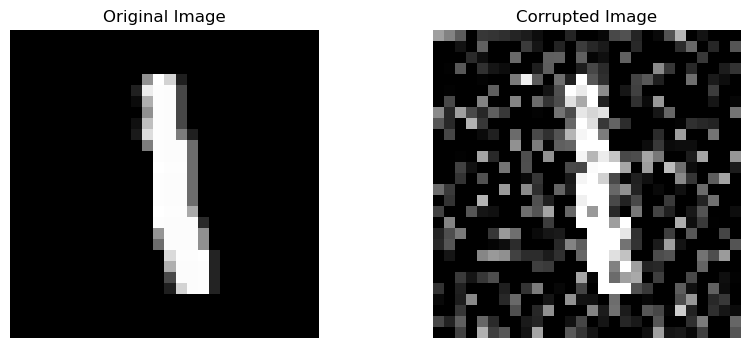

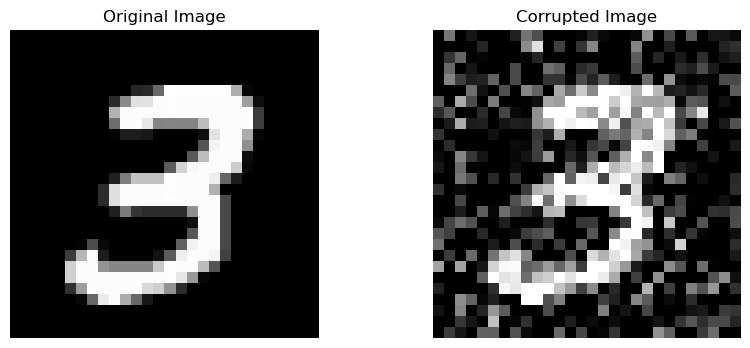

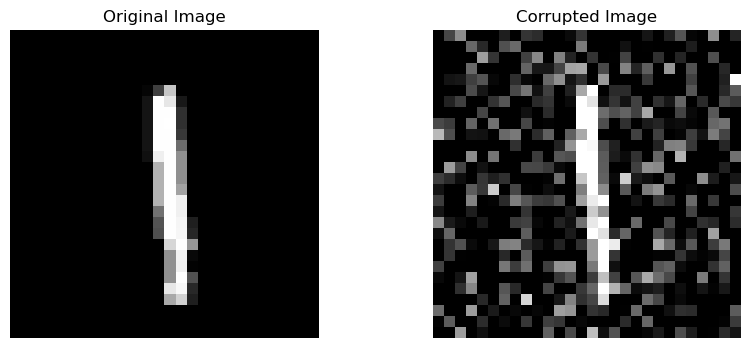

In [25]:
for i in range(9):
  # Create a figure with subplots
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
  corrupted, original = mnist_corrupt_train[i]

  # Plot each image
  axes[0].imshow(original.squeeze(), cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')  # Hide axes

  axes[1].imshow(corrupted.squeeze(), cmap='gray')
  axes[1].set_title('Corrupted Image')
  axes[1].axis('off')  # Hide axes

  # Display the plot
  plt.show()

In order to start training our denoising autoencoder, we need to define our loss function. We'll define our loss as the mean squared error between the output of the decoder and the original, uncorrupted image.

In [7]:
def denoise_loss(output, original):
  mse_loss = nn.MSELoss()
  return mse_loss(output, original)

Now that we corrupted our MNIST images, we can train our denoising autoencoder to reconstruct the original, uncorrupted images.  

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


def minibatch_loss(model, input_imgs, target_imgs):
    reconstructed_imgs = model(input_imgs)
    loss = denoise_loss(reconstructed_imgs, target_imgs)
    return loss

def minibatch_gd(model, num_epochs, train_set, test_set, lr=0.01):
  train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

  for _ in tqdm(range(num_epochs)):
    model.train()
    for corrupt_imgs, original_imgs in train_loader:
      loss = minibatch_loss(model, corrupt_imgs, original_imgs)
      loss.backward()
      for param in model.parameters():
        with torch.no_grad():
          param -= lr*param.grad
          param.grad = None

    model.eval()
    total_loss = 0
    with torch.no_grad():
      for corrupt_imgs, original_imgs in test_loader:
          loss = minibatch_loss(model, corrupt_imgs, original_imgs)
          total_loss += loss.item()

if __name__ == "__main__":
    train_set = mnist_corrupt_train
    test_set = mnist_corrupt_test
    num_epochs = 100
    model = DenoisingAutoencoder()
    minibatch_gd(model, num_epochs, train_set, test_set)
    torch.save(model.state_dict(), "mnistmodel100.pt")

Now that our model is trained, let's see how it performs on some of our test data!

In [ ]:
train_set = mnist_corrupt_train
test_set = mnist_corrupt_test
model = DenoisingAutoencoder()
# Pre-trained models are available for 1, 2, 10, 25, 50, 100, and 400 epochs
model.load_state_dict(torch.load('denoising_models/mnistmodel400.pt', map_location=torch.device('cpu')))
model.eval()

sample_indices = [100, 502, 800, 900]

for i in range(len(sample_indices)):
  input_image, original_image = test_set[sample_indices[i]]
  output_image = None

  with torch.no_grad():
      output_image = model(input_image)

  # Create a figure with subplots
  fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 3 columns

  # Plot each image
  axes[0].imshow(input_image.squeeze(), cmap='gray')
  axes[0].set_title('Corrupted Image')
  axes[0].axis('off')  # Hide axes

  axes[1].imshow(output_image.squeeze(), cmap='gray')
  axes[1].set_title('Denoised Output')
  axes[1].axis('off')  # Hide axes

  axes[2].imshow(original_image.squeeze(), cmap='gray')
  axes[2].set_title('Original Image')
  axes[2].axis('off')  # Hide axes

  # Display the plot
  plt.show()

As we can see, our denoising autoencoder does a pretty good job of taking our corrupted images and generating something that resembles the original image. The results we see come from 50 epoches of training. The more epoches we complete, the closer  the denoised output will be to the original image!

**Real World Applications**

As we've seen, denoising autoencoders are great at reducing the noise in images and extracting the important aspects of the image. This is why they're used for applications like:


*   Optical Character Recognition (OCR) - converting an image of text into machine-readable text
*   Handwritten Text Recognition - converting handwritten text into machine-readable text
*   Image Recovery - restoring corrupted images to recover their features





# Credits
* [Autoencoders (2021)](https://arxiv.org/pdf/2003.05991)
* [Introduction to Autoencoders: From The Basics to Advanced Applications in PyTorch](https://www.datacamp.com/tutorial/introduction-to-autoencoders)
* [Denoising Autoencoders Explained](https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2)
* [Denoising AutoEncoders Can Reduce Noise in Images](https://medium.com/game-of-bits/denoising-autoencoders-can-reduce-noise-in-images-5b74753eaf97)
* [How to Develop a CNN for MNIST Handwritten Digit Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)